# Linear regression model

## Fit an interpretable linear regression model and make global and local explanations

The idea is to fit an interpretable linear regression model, evaluate the model fit and the coefficients, and then interpret the predictions globally and locally.

The workflow is the following:

- Identify variables that are correlated with the target.
- Identify and remove high multi-colinearity among the predictors.
- Fit a linear model with the highest performance and least number of features
- Evaluate the model fit
- Evaluate the coefficients (global interpretation)
- Evaluate a few observations individually (local interpretation)

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.feature_selection import f_regression, r_regression, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from feature_engine.selection import SmartCorrelatedSelection

## Prepare house price data

In [2]:
# load dataset

data = pd.read_csv('../../houseprice_prep.csv')

data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,MiscFeature_Shed,SaleType_COD,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare
0,65.0,8450,7,5,5,5,196.0,4,3,4,...,0,0,0,0,1,0,0,1,0,0
1,80.0,9600,6,8,31,31,0.0,3,3,4,...,0,0,0,0,1,0,0,1,0,0
2,68.0,11250,7,5,7,6,162.0,4,3,4,...,0,0,0,0,1,0,0,1,0,0
3,60.0,9550,7,5,91,36,0.0,3,3,3,...,0,0,0,0,1,1,0,0,0,0
4,84.0,14260,8,5,8,8,350.0,4,3,4,...,0,0,0,0,1,0,0,1,0,0


In [3]:
# Separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 204), (146, 204))

In [4]:
# Scale data

scaler = StandardScaler().set_output(transform="pandas").fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Make target normally distributed

y_train = np.log(y_train)
y_test = np.log(y_test)

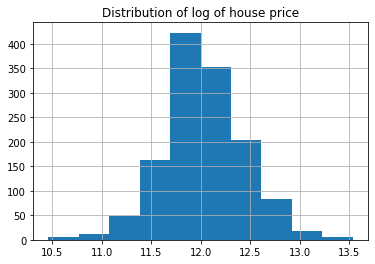

In [6]:
# Plot target variable

y_train.hist()
plt.title("Distribution of log of house price")
plt.show()

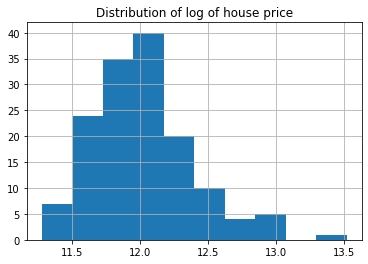

In [7]:
y_test.hist()
plt.title("Distribution of log of house price")
plt.show()

## Variable Distribution

Plot histograms of all continuous variables. 

Consider variables as continuous if they have more than 2 unique values. Otherwise, they are binary.

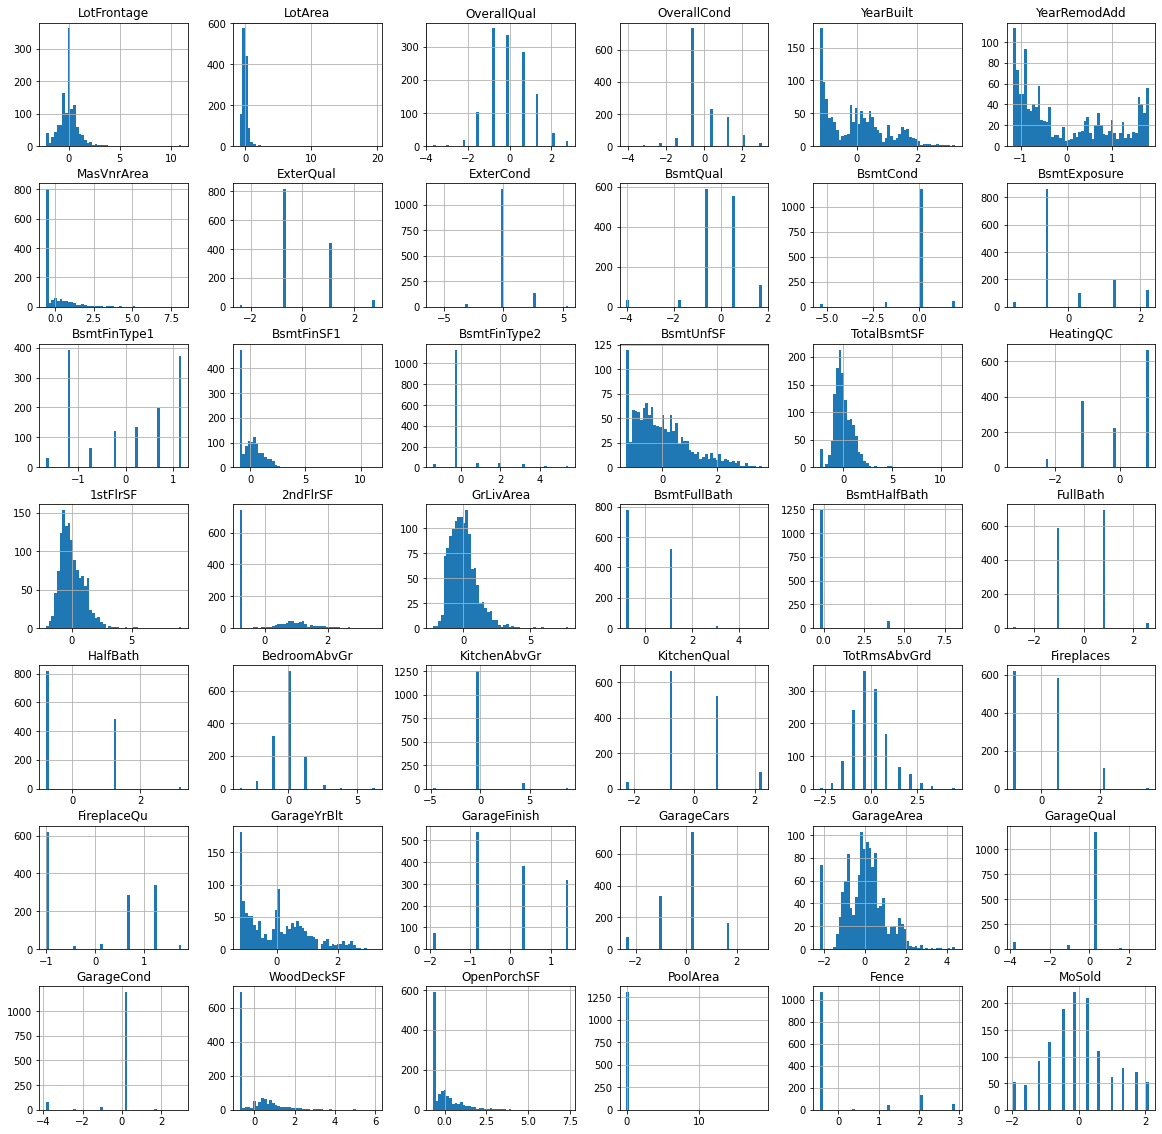

In [8]:
# Find continuous variables
var_continuous = [var for var in X_train.columns if X_train[var].nunique() > 2]

# PLot histograms of continuous variables.
X_train[var_continuous].hist(bins=50, figsize=(20, 20))
plt.show()

We see that among the variables that are not binary, we have some that are continuous and some that are discrete.

## Correlation with the target

Remove variables that have little linear association with the target. 

Use Pearson's correlation coefficient to determine the association. 

Remove variables whose absolute correlation coefficient is smaller than 0.1.

In [9]:
# calculate Pearson's correlation coefficient
coeffs = r_regression(X_train, y_train)

# Calculate significance of correlation coefficient
pvalues = f_regression(X_train, y_train)[1]

# Put together in a dataframe
corr_w_target = pd.DataFrame({
    "corrcoeff": np.abs(coeffs),  # absolute value
    "pvalue": pvalues,
}, index=X_train.columns,)

# order in descending order
corr_w_target.sort_values(by=["corrcoeff"], ascending=False, inplace=True)

corr_w_target.head()

,corrcoeff,pvalue
OverallQual,0.813593,2.870558e-311
GrLivArea,0.694044,1.852154e-189
GarageCars,0.691922,7.610282e-188
ExterQual,0.678667,4.468670e-178
KitchenQual,0.667120,5.612952e-170


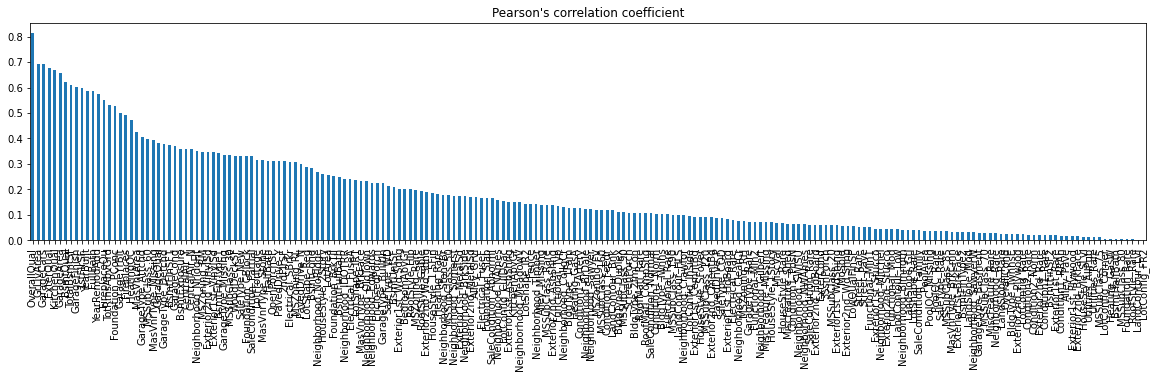

In [10]:
# plot the correlation coefficients

corr_w_target["corrcoeff"].plot.bar(figsize=(20, 4))
plt.title("Pearson's correlation coefficient")
plt.show()

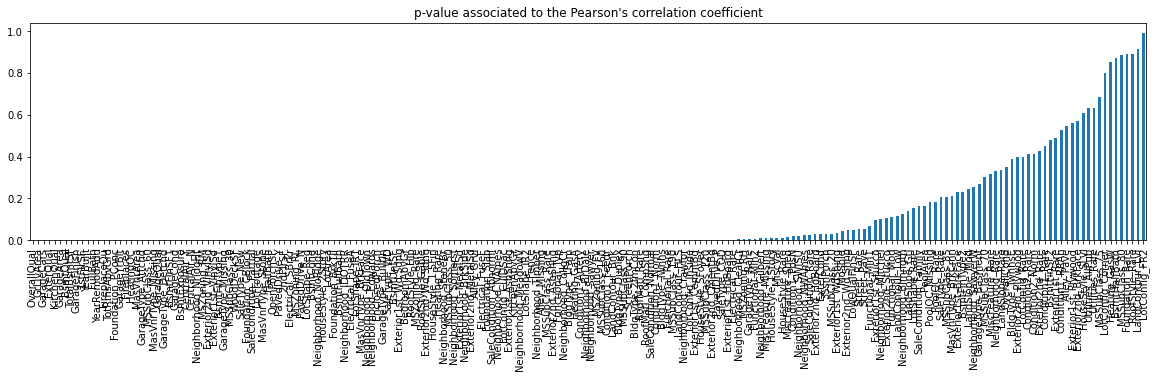

In [11]:
# plot the pvalues

corr_w_target["pvalue"].plot.bar(figsize=(20, 4))
plt.title("p-value associated to the Pearson's correlation coefficient")
plt.show()

In [12]:
# Select the variables whose absolute correlation coefficient is 
# greater than 0.1

predictors = corr_w_target.loc[corr_w_target["corrcoeff"] > 0.1]

variables = list(predictors.index)

len(variables)

119

## Evaluate multicolinearity

Utilizing solely the variables that exhibit a correlation coefficient greater than 0.1, as mentioned in the previous item, assess the correlations among all features within the dataset.

In [13]:
# Reduce data sets to the selected variables

X_train = X_train[variables]
X_test = X_test[variables]

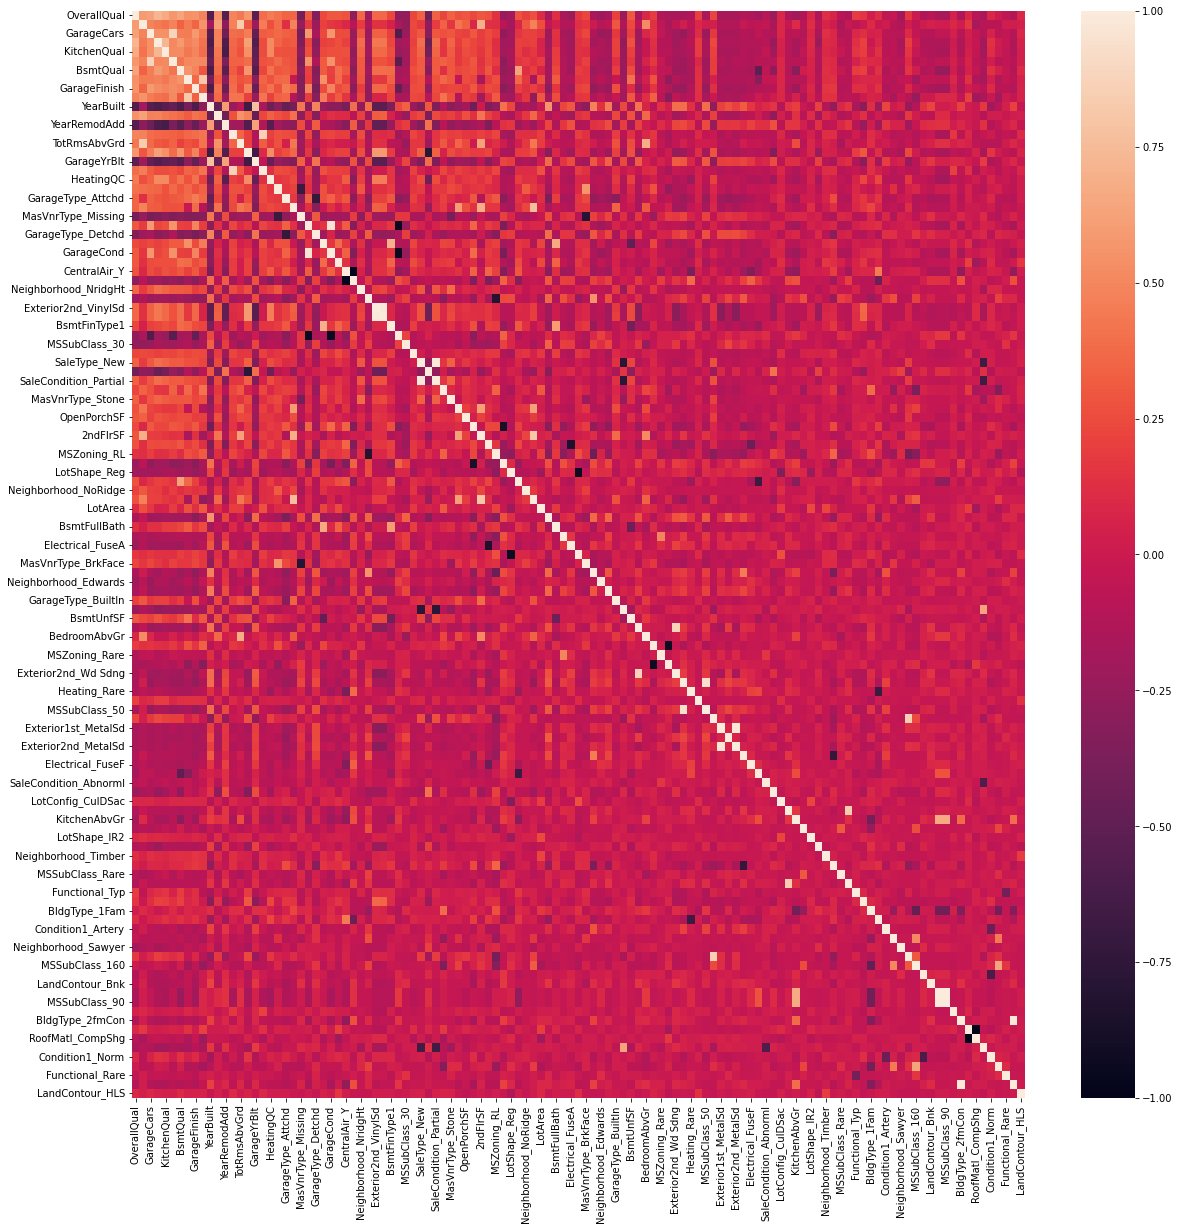

In [14]:
# We calculate the correlations using pandas corr()
# and we round the values to 2 decimals.
correlation_matrix = X_train.corr().round(2)

# Plot the correlation matrix usng seaborn.
# We use annot = True to print the correlation values
# inside the squares.

figure = plt.figure(figsize=(20, 20))
sns.heatmap(data=correlation_matrix)
plt.show()

## Remove multicolinearity 

Identify groups of variables that are correlated and retain the one with the greatest variability.

In [15]:
# I use this transformer from Feature-engine, but you may have as
# well done this manually.

sel = SmartCorrelatedSelection(threshold=0.8, selection_method='variance').fit(
    X_train, y_train)

# correlated variables
sel.correlated_feature_sets_

[{'GrLivArea', 'TotRmsAbvGrd'},
 {'GarageArea', 'GarageCars'},
 {'1stFlrSF', 'TotalBsmtSF'},
 {'FireplaceQu', 'Fireplaces'},
 {'GarageCond', 'GarageQual', 'GarageType_Missing'},
 {'CentralAir_N', 'CentralAir_Y'},
 {'MSZoning_RL', 'MSZoning_RM'},
 {'Exterior1st_VinylSd', 'Exterior2nd_VinylSd'},
 {'SaleCondition_Partial', 'SaleType_New'},
 {'PavedDrive_N', 'PavedDrive_Y'},
 {'2ndFlrSF', 'HouseStyle_2Story'},
 {'Electrical_FuseA', 'Electrical_SBrkr'},
 {'LotShape_IR1', 'LotShape_Reg'},
 {'Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng'},
 {'RoofStyle_Gable', 'RoofStyle_Hip'},
 {'HouseStyle_1.5Fin', 'MSSubClass_50'},
 {'MSZoning_FV', 'Neighborhood_Somerst'},
 {'Exterior1st_MetalSd', 'Exterior2nd_MetalSd'},
 {'Exterior1st_AsbShng', 'Exterior2nd_AsbShng'},
 {'BldgType_Duplex', 'MSSubClass_90'},
 {'BldgType_2fmCon', 'MSSubClass_190'},
 {'RoofMatl_CompShg', 'RoofMatl_Rare'}]

In [16]:
# Retain variable with highest variability from
# each group

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((1314, 96), (146, 96))

The number of features left may vary if you are using a different code implementation. Don't worry too much.

## Fit an interpretable linear model

Using Lasso, train the model that performs the best and has the least number of features.

If you get errors, reduce the penalization.

In [17]:
n_feat_mean = []
n_feat_std = []
r_test_mean = []
r_test_std = []

alphas =[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

for a in alphas:

    sel_ = Pipeline([
        ("selector", SelectFromModel(Lasso(alpha=a, random_state=10))),
        ("lasso", Lasso(alpha=a, random_state=10))])

    results = cross_validate(
        estimator=sel_,
        X=X_train,
        y=y_train,
        scoring="r2",
        cv=5,
        return_estimator=True,
    )

    n_feat_mean.append(np.mean(
        [len(results["estimator"][i][:-1].get_feature_names_out()) for i in range(5)]))
    n_feat_std.append(np.std(
        [len(results["estimator"][i][:-1].get_feature_names_out()) for i in range(5)]))

    r_test_mean.append(np.mean(results["test_score"]))
    r_test_std.append(np.std(results["test_score"]))

In [18]:
scores = pd.DataFrame({
    "alpha": pd.Series(alphas),
    "n_feat_mean": pd.Series(n_feat_mean),
    "n_feat_std": pd.Series(n_feat_std),
    "r_test_mean": pd.Series(r_test_mean),
    "r_test_std": pd.Series(r_test_std),
})

scores

,alpha,n_feat_mean,n_feat_std,r_test_mean,r_test_std
0,0.001,83.2,3.709447,0.866307,0.029801
1,0.010,43.2,1.939072,0.853947,0.026450
2,0.020,31.0,2.097618,0.836282,0.020514
3,0.030,22.6,0.800000,0.816790,0.015082
4,0.040,18.6,1.496663,0.799447,0.012070
5,0.050,15.4,1.019804,0.779987,0.013311
6,0.100,6.6,0.489898,0.665553,0.028490


Text(0, 0.5, 'r2 in test set')

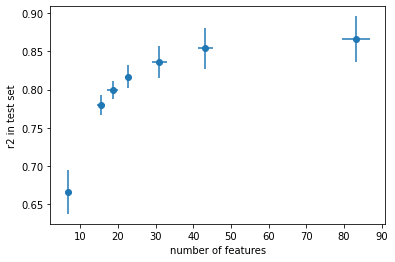

In [19]:
plt.errorbar(
    scores["n_feat_mean"],
    scores["r_test_mean"],
    xerr=scores["n_feat_std"],
    yerr=scores["r_test_std"],
    marker="o",
    ls = "",
    )

plt.xlabel("number of features")
plt.ylabel("r2 in test set")

## Fit model and evaluate fit

Fit a linear model with a penalization of 0.04 and determine if it is a good fit to the data.

In [20]:
# penalization
alpha = 0.04

# fit model
model = Pipeline([
    ("selector", SelectFromModel(Lasso(alpha=alpha, random_state=10))),
    ("lasso", Lasso(alpha=alpha, random_state=10))])

model.fit(X_train, y_train)

# r2 in train set
model.score(X_train, y_train)

0.812229746733644

In [21]:
# r2 in test set
model.score(X_test, y_test)

0.8439024619278577

In [22]:
# SST - total sum of squares

SST = np.sum((y_train - y_train.mean())**2)

SST

212.80853415059386

In [23]:
# SSR - sum of squares of the residuals

SSR = np.sum((y_train - model.predict(X_train))**2)

SSR

39.95911235469898

In [24]:
# SSM - sum of squares of the model

SSM = SST - SSR

SSM

172.84942179589487

In [25]:
# mean sum of squares of the model

df1 = len(X_train.columns)

MSM = SSM / df1

MSM

1.8005148103739048

In [26]:
# mean sum of squares of the residuals

df2 = (len(X_train)-len(X_train.columns))

MSR = SSR / df2

MSR

0.03280715300057387

In [27]:
# F-ratio

F = MSM/MSR

F

54.88177564028216

In [28]:
p_value = 1 - stats.f.cdf(F, df1, df2)

p_value

1.1102230246251565e-16

[]

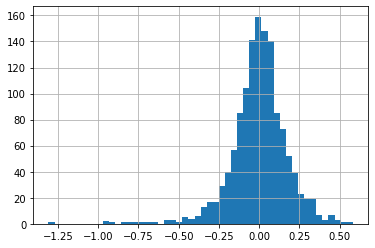

In [29]:
# plot the residuals

(y_train - model.predict(X_train)).hist(bins=50)
plt.plot()

The model explains >80% of the variability and the p-value is really small.

The residuals are centered at 0, although the distribution is not strictly normal. There are a few extreme values towards the left of the histogram.

The linear model is a fairly good fit of the data.

## Evaluate the model globally

Let's now try to interpret the model globally. For this we need to determine:

- Coefficient magnitude and sign
- Coefficient significance (t statistic and p-value)
- Effects plot

Determine the error using cross-validation.

In [30]:
alpha = 0.04

pipe = Pipeline([
    ("selector", SelectFromModel(Lasso(alpha=alpha, random_state=10))),
    ("lasso", Lasso(alpha=alpha, random_state=10))])

In [31]:
results = cross_validate(
    estimator=pipe,
    X=X_train,
    y=y_train,
    scoring="r2",
    cv=5,
    return_train_score=True,
    return_estimator=True,
)

In [32]:
# Collect coefficients in dataframe

coeffs = []

for estimator in results["estimator"]:

    dictionary = dict(
        zip(
            estimator.named_steps["selector"].get_feature_names_out(),
            estimator.named_steps["lasso"].coef_, 
        )
    )
    coeffs.append(dictionary)
    
coeffs = pd.DataFrame(coeffs).T

coeffs

,0,1,2,3,4
OverallQual,0.141638,0.139638,0.129546,0.131594,0.152360
GarageCars,0.054348,0.051917,0.058772,0.062169,0.059377
ExterQual,0.003429,0.006615,0.006027,0.011012,0.000517
KitchenQual,0.019690,0.029274,0.029749,0.021414,0.017629
BsmtQual,0.000328,0.002646,0.012265,0.014169,0.008869
TotalBsmtSF,0.049462,0.039319,0.024815,0.030624,0.023674
GarageFinish,0.012933,0.010727,0.011202,0.010057,0.009143
FullBath,0.015813,0.009686,0.005787,0.009358,0.011248
YearRemodAdd,-0.020604,-0.020239,-0.021245,-0.021673,-0.024291
FireplaceQu,0.023650,0.031717,0.028633,0.029427,0.030004


### Calculate the t-statistic and p-value

In [33]:
# Remove features that were not selected at 
# each cross-validation round

coeffs.dropna(inplace=True)

# find the mean, and std of the coefficients
coeffs[["mean", "std"]] = coeffs.agg(["mean", "std"], axis=1)

# calculate the t-statistic
coeffs["t"] = coeffs["mean"] / coeffs["std"]

coeffs

,0,1,2,3,4,mean,std,t
OverallQual,0.141638,0.139638,0.129546,0.131594,0.152360,0.138955,0.009084,15.296798
GarageCars,0.054348,0.051917,0.058772,0.062169,0.059377,0.057317,0.004119,13.913878
ExterQual,0.003429,0.006615,0.006027,0.011012,0.000517,0.005520,0.003906,1.413302
KitchenQual,0.019690,0.029274,0.029749,0.021414,0.017629,0.023551,0.005606,4.200978
BsmtQual,0.000328,0.002646,0.012265,0.014169,0.008869,0.007655,0.005998,1.276202
TotalBsmtSF,0.049462,0.039319,0.024815,0.030624,0.023674,0.033579,0.010827,3.101499
GarageFinish,0.012933,0.010727,0.011202,0.010057,0.009143,0.010812,0.001415,7.639689
FullBath,0.015813,0.009686,0.005787,0.009358,0.011248,0.010378,0.003637,2.853902
YearRemodAdd,-0.020604,-0.020239,-0.021245,-0.021673,-0.024291,-0.021610,0.001598,-13.522127
FireplaceQu,0.023650,0.031717,0.028633,0.029427,0.030004,0.028686,0.003035,9.453207


In [34]:
# degrees of freedom

N = np.round(len(X_train) / 5, 0) # number of obs in each CV round
p = len(coeffs) # number of features

df = N - p - 1

df

247.0

In [35]:
# the p-values

coeffs["pvalues"] = stats.t.sf(np.abs(coeffs["t"]), df=df)*2

coeffs

,0,1,2,3,4,mean,std,t,pvalues
OverallQual,0.141638,0.139638,0.129546,0.131594,0.152360,0.138955,0.009084,15.296798,1.299699e-37
GarageCars,0.054348,0.051917,0.058772,0.062169,0.059377,0.057317,0.004119,13.913878,6.927732e-33
ExterQual,0.003429,0.006615,0.006027,0.011012,0.000517,0.005520,0.003906,1.413302,1.588260e-01
KitchenQual,0.019690,0.029274,0.029749,0.021414,0.017629,0.023551,0.005606,4.200978,3.714496e-05
BsmtQual,0.000328,0.002646,0.012265,0.014169,0.008869,0.007655,0.005998,1.276202,2.030827e-01
TotalBsmtSF,0.049462,0.039319,0.024815,0.030624,0.023674,0.033579,0.010827,3.101499,2.149020e-03
GarageFinish,0.012933,0.010727,0.011202,0.010057,0.009143,0.010812,0.001415,7.639689,4.789757e-13
FullBath,0.015813,0.009686,0.005787,0.009358,0.011248,0.010378,0.003637,2.853902,4.684992e-03
YearRemodAdd,-0.020604,-0.020239,-0.021245,-0.021673,-0.024291,-0.021610,0.001598,-13.522127,1.486381e-31
FireplaceQu,0.023650,0.031717,0.028633,0.029427,0.030004,0.028686,0.003035,9.453207,2.663923e-18


### Find non significant coefficients

Identify coefficients with p-value greater than 0.05

In [36]:
coeffs[coeffs["pvalues"]>0.05]

,0,1,2,3,4,mean,std,t,pvalues
ExterQual,0.003429,0.006615,0.006027,0.011012,0.000517,0.005520,0.003906,1.413302,0.158826
BsmtQual,0.000328,0.002646,0.012265,0.014169,0.008869,0.007655,0.005998,1.276202,0.203083
BsmtFinSF1,0.026731,0.002175,0.010308,0.002193,0.008760,0.010033,0.010046,0.998709,0.318913
BsmtFinType1,0.000132,0.013732,0.004941,0.012897,0.012015,0.008743,0.005947,1.470190,0.142783


Based on a t-test, those coefficients are not significantly different from 0 and therefore these variables do not provide a contribution towards the target value or house price.

We should remove them from the final model. For now, we continue with the demo. 

### Global interpretability

PLot the magnitude and sign of the coefficients, the absolute value and the t, draw some conclusions.

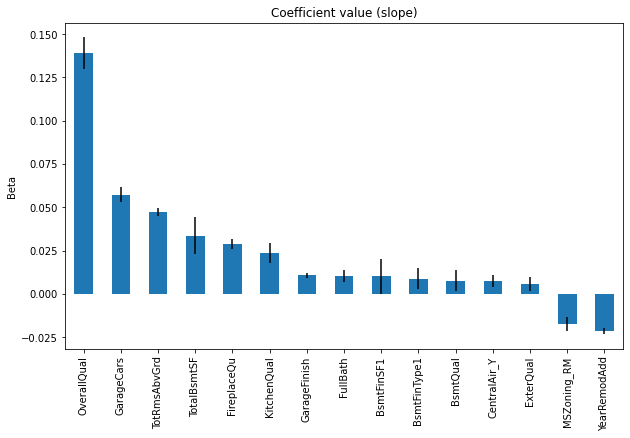

In [37]:
# net value of the coefficient

s = pd.Series(
    coeffs["mean"],
    index=coeffs.index,
)

s.sort_values(ascending=False).plot.bar(yerr=coeffs["std"], figsize=(10, 6))
plt.ylabel("Beta")
plt.title("Coefficient value (slope)")
plt.show()

Based on the magnitude of the coefficients, the `OveralQual` seems to be the most important variable for the house price.

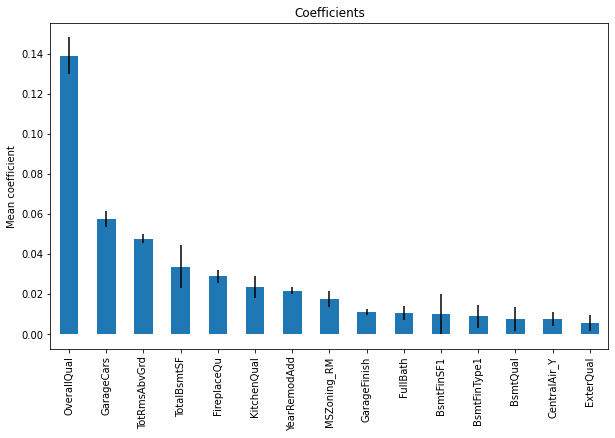

In [38]:
# plot absolute value of coefficient plus std

coeffs["mean"].abs().sort_values(ascending=False).plot.bar(yerr=coeffs["std"], figsize=(10,6))
plt.ylabel("Mean coefficient")
plt.title("Coefficients")
plt.show()

The variables `HeatingQC` and `ExternalQual` seem to be the least important. Their p-values were also not significant.

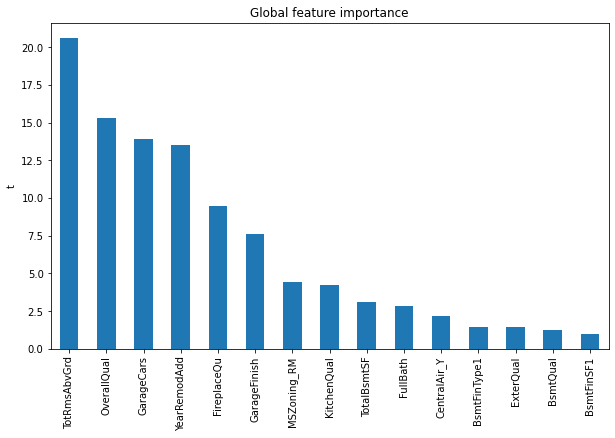

In [39]:
# plot t

coeffs["t"].abs().sort_values(ascending=False).plot.bar(figsize=(10,6))
plt.ylabel("t")
plt.title("Global feature importance")
plt.show()

The last 3 variables are those whose p-values are non-significant.

### Effect plots

Draw the effects plot.

Text(0, 0.5, 'Effects (coeff x feature)')

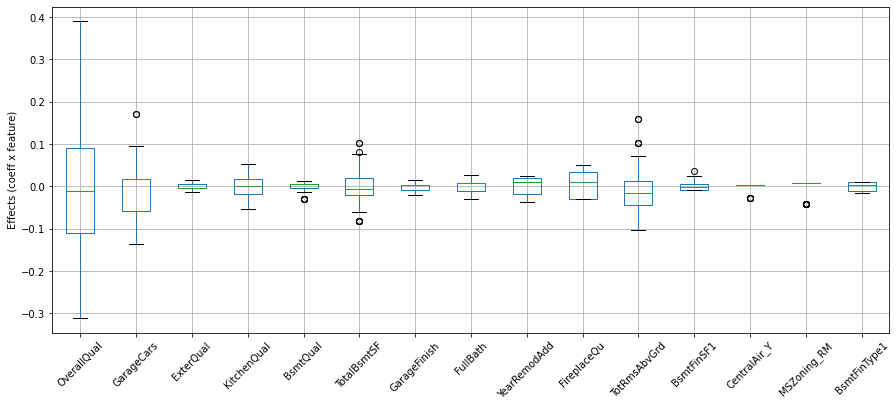

In [40]:
# multiply the coefficients by the feature values

effects = coeffs["mean"] * X_test[coeffs.index]

# plot the effects
effects.boxplot(figsize=(15,6), rot=45)
plt.ylabel("Effects (coeff x feature)")

## Local interpretability

Compare the prediction of the model with the real price and then interpret the contribution of each variable towards its final price.

Find how the observation compares with the rest of the observations in the test set.

Evaluate the following rows (they are from the test set):

- #1000
- #224
- #491

In [41]:
# Observation 1000
obs= 1000

# get prediction
pred = model.predict(X_test.loc[obs, :].to_frame().T)

# house price
np.exp(pred)

array([85200.41877776])

In [42]:
# real value

np.exp(y_test.loc[obs])

82000.00000000007

In [43]:
# difference

np.exp(y_test.loc[obs]) - np.exp(pred)

array([-3200.41877776])

The model over-estimated the value.

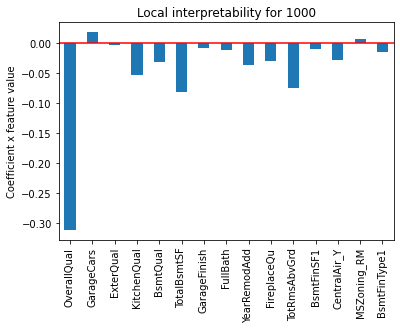

In [44]:
# local explanation

effect = coeffs["mean"] * X_test.loc[obs, coeffs.index]

effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Coefficient x feature value")
plt.title(f"Local interpretability for {obs}")
plt.show()

Text(0, 0.5, 'Effects (coeff x feature)')

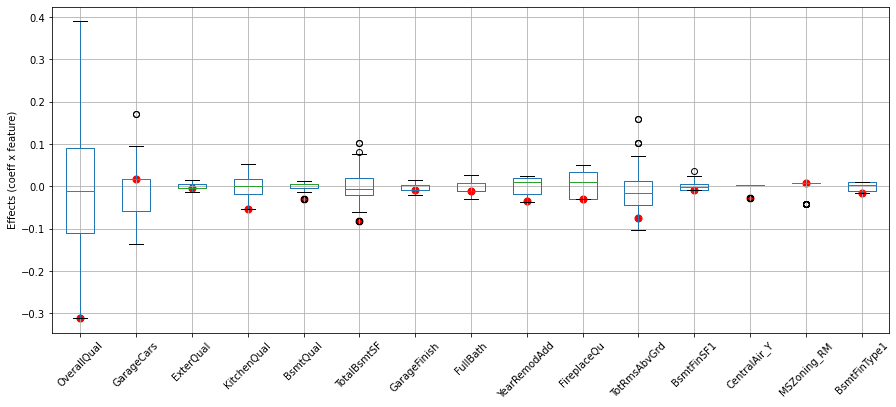

In [45]:
# overlay the individual observation to the effects

effects.boxplot(figsize=(15,6), positions=range(len(effects.columns)), rot=45)
plt.scatter(effects.columns, effect,  marker='o', color="r", s=50)
plt.ylabel("Effects (coeff x feature)")

In [46]:
# Observation 224
obs= 224

# get prediction
pred = model.predict(X_test.loc[obs, :].to_frame().T)

# house price
np.exp(pred)

array([378829.06173491])

In [47]:
# real value

np.exp(y_test.loc[obs])

386250.00000000006

In [48]:
# difference

np.exp(y_test.loc[obs]) - np.exp(pred)

array([7420.93826509])

The model over estimates the price.

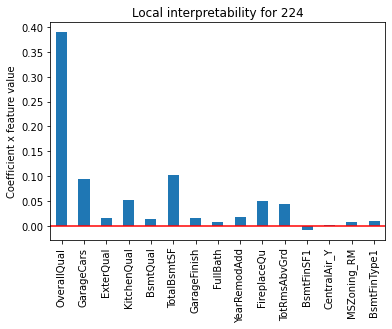

In [49]:
# local explanations

effect = coeffs["mean"] * X_test.loc[obs, coeffs.index]

effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Coefficient x feature value")
plt.title(f"Local interpretability for {obs}")
plt.show()

Text(0, 0.5, 'Effects (coeff x feature)')

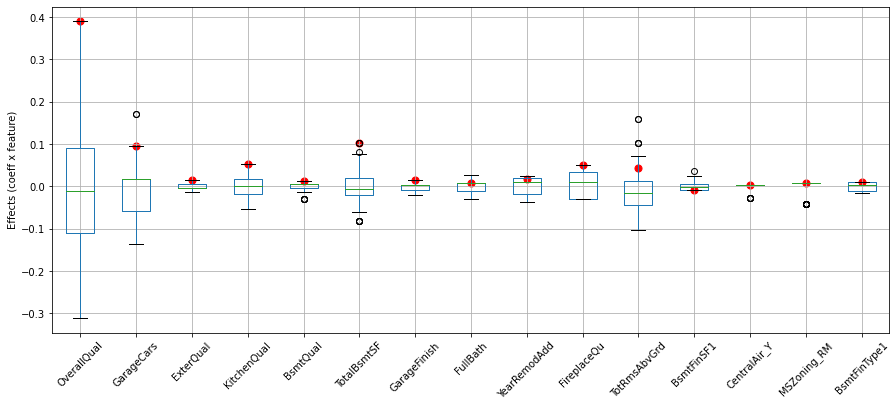

In [50]:
# overlay the individual observation to the effects

effects.boxplot(figsize=(15,6), positions=range(len(effects.columns)), rot=45)
plt.scatter(effects.columns, effect,  marker='o', color="r", s=50)
plt.ylabel("Effects (coeff x feature)")

In [51]:
# Observation 224
obs= 491

# get prediction
pred = model.predict(X_test.loc[obs, :].to_frame().T)

# house price
np.exp(pred)

array([133788.93061885])

In [52]:
# real value

np.exp(y_test.loc[obs])

132999.99999999997

In [53]:
# difference

np.exp(y_test.loc[obs]) - np.exp(pred)

array([-788.93061885])

The model over-estimates the price again.

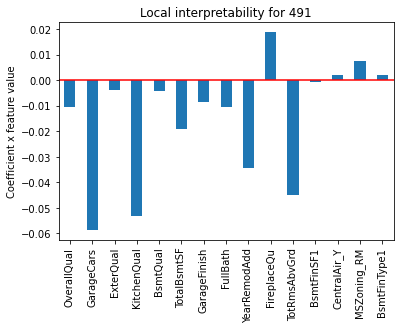

In [54]:
effect = coeffs["mean"] * X_test.loc[obs, coeffs.index]

effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Coefficient x feature value")
plt.title(f"Local interpretability for {obs}")
plt.show()

Text(0, 0.5, 'Effects (coeff x feature)')

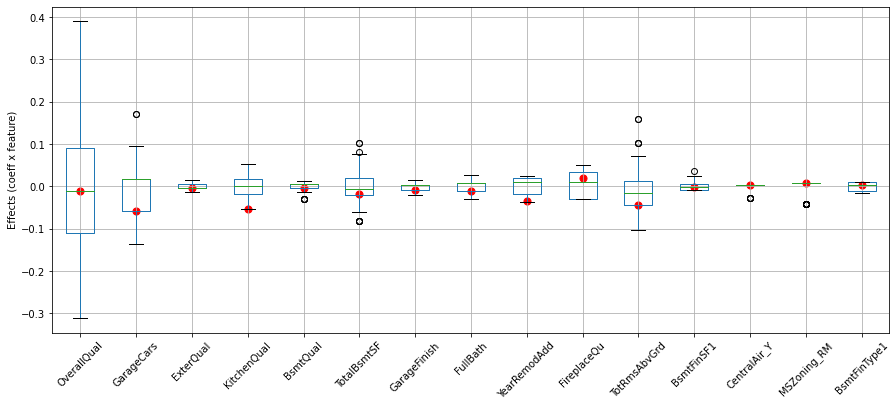

In [55]:
# overlay the individual observation to the effects

effects.boxplot(figsize=(15,6), positions=range(len(effects.columns)), rot=45)
plt.scatter(effects.columns, effect,  marker='o', color="r", s=50)
plt.ylabel("Effects (coeff x feature)")